In [2]:
import math
from typing import Tuple
import numpy as np
import pandas as pd


def load_students_csv() -> pd.DataFrame:
    candidates = [
        "students_simple.csv",
    ]
    last_err = None
    for path in candidates:
        try:
            df = pd.read_csv(path)
            return df
        except Exception as e:
            last_err = e
    raise RuntimeError(f"Не удалось загрузить CSV. Последняя ошибка: {last_err}")


df_raw = load_students_csv()

df = df_raw.select_dtypes(include=[np.number]).copy()

N = 4
idx1 = N % 5
idx2 = (N * N) % 5 + 5

col_x = df.columns[idx1]
col_y = df.columns[idx2]

x = df[col_x].astype(float).to_numpy()
y = df[col_y].astype(float).to_numpy()

mask = np.isfinite(x) & np.isfinite(y)
x = x[mask]
y = y[mask]


print(f"Выбраны столбцы по формулам при N={N}:")
print(f"  X := df['{col_x}']")
print(f"  Y := df['{col_y}']")
print(f"Размер выборки: n = {x.size}\n")
print(x)
print(y)

Выбраны столбцы по формулам при N=4:
  X := df['pages']
  Y := df['bmi']
Размер выборки: n = 20

[24. 32. 24. 24. 60. 16. 90. 24. 48. 24. 16. 48. 32. 48. 64. 48. 90. 48.
 32. 60.]
[3.533 2.623 2.875 3.375 3.    2.828 3.255 2.726 2.429 2.361 2.342 2.672
 2.356 2.559 2.173 2.095 2.342 2.011 2.691 2.021]


In [4]:
# === 3) Коэффициент Фехнера ===
# r_F = (N_same - N_diff) / (N_same + N_diff)
def fechner_sign_corr(x: np.ndarray, y: np.ndarray) -> float:
    mean_x, mean_y = x.mean(), y.mean()

    sx = np.sign(x - mean_x)
    sy = np.sign(y - mean_y)

    # учитываем только наблюдения, где знак не равен нулю
    valid = (sx != 0) & (sy != 0)
    if not valid.any():
        return np.nan

    sx = sx[valid]
    sy = sy[valid]

    same = np.sum(sx == sy)
    diff = np.sum(sx != sy)

    total = same + diff
    if total == 0:
        return np.nan

    return (same - diff) / total


r_fechner = fechner_sign_corr(x, y)


# === 4) Корреляция Пирсона и доверительный интервал ===
def pearson_with_ci(a: np.ndarray, b: np.ndarray) -> Tuple[float, float, float]:
    r = float(np.corrcoef(a, b)[0, 1])
    n = len(a)

    # z-преобразование Фишера
    z_val = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    z_crit = 1.96

    left_z = z_val - z_crit * se
    right_z = z_val + z_crit * se

    return r, np.tanh(left_z), np.tanh(right_z)


r_pearson, ci_low, ci_high = pearson_with_ci(x, y)


# === 5) Спирмен ===
def to_ranks(arr: np.ndarray) -> np.ndarray:
    return pd.Series(arr).rank().to_numpy()

rank_x = to_ranks(x)
rank_y = to_ranks(y)
rho_s = float(np.corrcoef(rank_x, rank_y)[0, 1])


# === 6) Кенделл τ ===
def kendall_tau(a: np.ndarray, b: np.ndarray) -> float:
    N = len(a)
    concord = 0
    discord = 0
    tie_x = 0
    tie_y = 0

    for i in range(N - 1):
        dx = a[i+1:] - a[i]
        dy = b[i+1:] - b[i]

        sx = np.sign(dx)
        sy = np.sign(dy)

        tie_x += np.sum(sx == 0)
        tie_y += np.sum(sy == 0)

        mask = (sx != 0) & (sy != 0)
        prod = sx[mask] * sy[mask]

        concord += np.sum(prod > 0)
        discord += np.sum(prod < 0)

    total_pairs = N * (N - 1) // 2

    denom = np.sqrt((total_pairs - tie_x) * (total_pairs - tie_y))
    if denom == 0:
        return np.nan

    return (concord - discord) / denom


tau_k = kendall_tau(x, y)


# === Вывод результатов ===
print("=== Корреляционный анализ ===")
print(f"Фехнер: τ_F = {r_fechner: .6f}")
print(f"Пирсон: r = {r_pearson: .6f} | 95% ДИ: [{ci_low: .6f}; {ci_high: .6f}]")
print(f"Спирмен: ρ = {rho_s: .6f}")
print(f"Кенделл: τ = {tau_k: .6f}")

summary = pd.DataFrame({
    "Metric": ["Fechner", "Pearson", "Pearson CI low", "Pearson CI high", "Spearman", "Kendall"],
    "Value": [r_fechner, r_pearson, ci_low, ci_high, rho_s, tau_k]
})

print("\nСводная таблица:")
display(summary)


=== Корреляционный анализ ===
Фехнер: τ_F = -0.400000
Пирсон: r = -0.179497 | 95% ДИ: [-0.576252;  0.285726]
Спирмен: ρ = -0.323940
Кенделл: τ = -0.244239

Сводная таблица:


,Metric,Value
0,Fechner,-0.400000
1,Pearson,-0.179497
2,Pearson CI low,-0.576252
3,Pearson CI high,0.285726
4,Spearman,-0.323940
5,Kendall,-0.244239


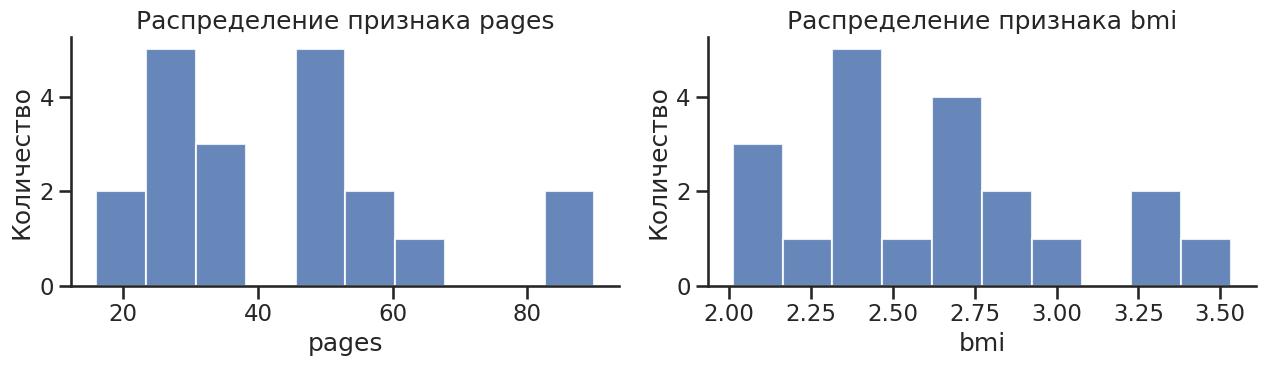

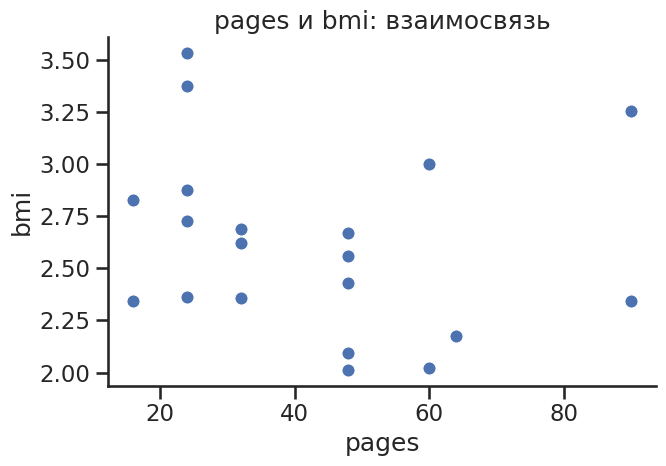

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# другой стиль оформления
sns.set_style("ticks")
sns.set_context("talk")

# --- Гистограммы ---
fig, axes = plt.subplots(ncols=2, figsize=(13, 4))
ax1, ax2 = axes

ax1.hist(x, bins=10, alpha=0.85)
ax1.set_title(f"Распределение признака {col_x}")
ax1.set_xlabel(col_x)
ax1.set_ylabel("Количество")

ax2.hist(y, bins=10, alpha=0.85)
ax2.set_title(f"Распределение признака {col_y}")
ax2.set_xlabel(col_y)
ax2.set_ylabel("Количество")

sns.despine()
plt.tight_layout()
plt.show()

# --- Диаграмма рассеяния ---
plt.figure(figsize=(7, 5))
sns.scatterplot(x=x, y=y, s=90, edgecolor="white", linewidth=0.8)

plt.title(f"{col_x} и {col_y}: взаимосвязь")
plt.xlabel(col_x)
plt.ylabel(col_y)

sns.despine()
plt.tight_layout()
plt.show()


,Модель,Уравнение,R²
0,Линейная,y = -0.0036x + 2.7650,0.032219
1,Квадратичная,y = 0.000327x² + -0.0371x + 3.4518,0.182979
2,Гиперболическая,y = 7.3407/x + 2.3922,0.066992
3,Показательная,y = 2.7439 · (0.9986)^x,0.028906


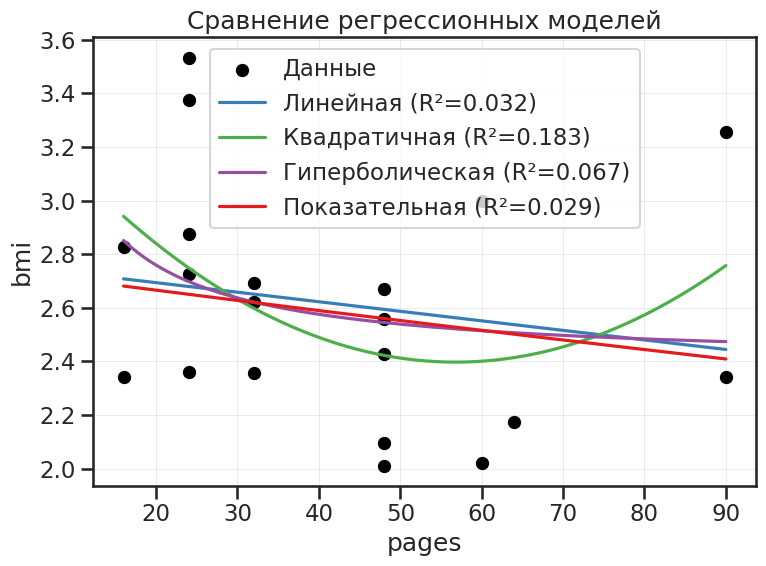

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Функция для расчёта коэффициента детерминации ---
def calc_r2(actual, predicted):
    diff_res = np.sum((actual - predicted)**2)
    diff_tot = np.sum((actual - actual.mean())**2)
    return 1.0 - diff_res / diff_tot


# === 1) Линейная модель ===
x_avg, y_avg = x.mean(), y.mean()

cov_xy = np.sum((x - x_avg) * (y - y_avg))
var_x = np.sum((x - x_avg) ** 2)

a_lin = cov_xy / var_x
b_lin = y_avg - a_lin * x_avg

y_hat_lin = a_lin * x + b_lin
r2_lin = calc_r2(y, y_hat_lin)


# === 2) Квадратичная регрессия y = ax² + bx + c ===
M_quad = np.column_stack([x**2, x, np.ones_like(x)])
coef_quad = np.linalg.lstsq(M_quad, y, rcond=None)[0]
a_q, b_q, c_q = coef_quad

y_hat_quad = a_q * x**2 + b_q * x + c_q
r2_quad = calc_r2(y, y_hat_quad)


# === 3) Гиперболическая модель y = a/x + b ===
M_h = np.column_stack([1.0 / x, np.ones_like(x)])
coef_h = np.linalg.lstsq(M_h, y, rcond=None)[0]
a_h, b_h = coef_h

y_hat_h = a_h / x + b_h
r2_h = calc_r2(y, y_hat_h)


# === 4) Экспоненциальная модель y = A · B^x ===
# Линеаризация: ln(y) = ln(A) + x·ln(B)
valid = y > 0
M_exp = np.column_stack([x[valid], np.ones(valid.sum())])
log_y = np.log(y[valid])

k_exp, m_exp = np.linalg.lstsq(M_exp, log_y, rcond=None)[0]

B = np.exp(k_exp)
A = np.exp(m_exp)

y_hat_exp = A * (B ** x)
r2_exp = calc_r2(y, y_hat_exp)


# === Таблица результатов ===
df_models = pd.DataFrame({
    "Модель": ["Линейная", "Квадратичная", "Гиперболическая", "Показательная"],
    "Уравнение": [
        f"y = {a_lin:.4f}x + {b_lin:.4f}",
        f"y = {a_q:.6f}x² + {b_q:.4f}x + {c_q:.4f}",
        f"y = {a_h:.4f}/x + {b_h:.4f}",
        f"y = {A:.4f} · ({B:.4f})^x"
    ],
    "R²": [r2_lin, r2_quad, r2_h, r2_exp]
})

display(df_models)


# === Графическое сравнение моделей ===
plt.figure(figsize=(8, 6))

plt.scatter(x, y, color="#000000", label="Данные", s=65)

x_dense = np.linspace(x.min(), x.max(), 300)

plt.plot(x_dense, a_lin * x_dense + b_lin,
         label=f"Линейная (R²={r2_lin:.3f})",
         color="#377eb8", linewidth=2.3)

plt.plot(x_dense, a_q * x_dense**2 + b_q * x_dense + c_q,
         label=f"Квадратичная (R²={r2_quad:.3f})",
         color="#4daf4a", linewidth=2.3)

plt.plot(x_dense, a_h / x_dense + b_h,
         label=f"Гиперболическая (R²={r2_h:.3f})",
         color="#984ea3", linewidth=2.3)

plt.plot(x_dense, A * (B ** x_dense),
         label=f"Показательная (R²={r2_exp:.3f})",
         color="#e41a1c", linewidth=2.3)

plt.xlabel(col_x)
plt.ylabel(col_y)
plt.title("Сравнение регрессионных моделей")
plt.grid(True, linewidth=0.4, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
from scipy.stats import f as fisher_dist

# список моделей: (название, предсказания, число параметров)
reg_models = [
    ("Линейная", y_hat_lin, 2),
    ("Квадратичная", y_hat_quad, 3),
    ("Гиперболическая", y_hat_h, 2),
    ("Показательная", y_hat_exp, 2)
]

# выбираем лучшую и худшую по R²
r2_all = [calc_r2(y, m[1]) for m in reg_models]
idx_best = int(np.argmax(r2_all))
idx_worst = int(np.argmin(r2_all))

best_label, best_pred, best_p = reg_models[idx_best]
worst_label, worst_pred, worst_p = reg_models[idx_worst]


# --- Функция F-критерия ---
def f_statistic(y_obs, y_fit, k, alpha=0.05):
    """
    Проверка регрессионной модели по критерию Фишера.
    Формула:
        F = (R² / (k - 1)) / ((1 - R²) / (n - k))
    """
    n = len(y_obs)
    r2 = calc_r2(y_obs, y_fit)

    num = r2 / (k - 1)
    den = (1 - r2) / (n - k)

    F_val = num / den
    F_critical = fisher_dist.ppf(1 - alpha, k - 1, n - k)

    return F_val, F_critical, (F_val > F_critical)


# считаем для лучших/худших
F_b, Fc_b, ok_b = f_statistic(y, best_pred, best_p)
F_w, Fc_w, ok_w = f_statistic(y, worst_pred, worst_p)

# --- вывод ---
print("=== Оценка моделей по F-критерию (α = 0.05) ===\n")

print(f"Наиболее точная модель: {best_label}")
print(f"  F факт = {F_b:.4f},   F крит = {Fc_b:.4f}")
print(f"  → {'Проходит проверку значимости' if ok_b else 'Не проходит тест значимости'}\n")

print(f"Наименее точная модель: {worst_label}")
print(f"  F факт = {F_w:.4f},   F крит = {Fc_w:.4f}")
print(f"  → {'Проходит проверку значимости' if ok_w else 'Не является статистически значимой'}")


=== Оценка моделей по F-критерию (α = 0.05) ===

Наиболее точная модель: Квадратичная
  F факт = 1.9036,   F крит = 3.5915
  → Не проходит тест значимости

Наименее точная модель: Показательная
  F факт = 0.5358,   F крит = 4.4139
  → Не является статистически значимой
